# Global Ads Performance - Battle of the Platforms


1. Executive Summary
This project investigates global advertising performance across three major platforms: TikTok, Meta, and Google Ads. By leveraging a multi-country, multi-industry dataset, we aim to determine which platform offers the highest efficiency and build predictive models to forecast campaign success. Our methodology follows a rigorous data science pipeline including data cleaning, robustness testing through noise injection, statistical hypothesis testing, and a hybrid machine learning approach (Supervised + Unsupervised).


2. Dataset Selection
Source: Global Ads Performance Dataset.
Features: 14 features (Platform, Industry, Country, Impressions, Clicks, Ad Spend, Conversions, Revenue, etc.).
Type: Hybrid (Regression for conversion forecasting and Classification for profitability prediction).



3. Problem Statement


1. Platform ROI Comparison:To test whether ROAS differs significantly across TikTok, Meta, and Google platforms.

2. Conversion Forecasting (Regression):To predict campaign conversions using engagement metrics and campaign features through supervised learning.

3. Profitability Classification:To classify campaigns as profitable (ROAS > 1) using pre-revenue performance indicators.

4. Market Segment Discovery (Unsupervised): To identify latent campaign performance segments and global archetypes using PCA and K-Means clustering.


4. Technical Roadmap 


1. Preprocessing

2. Noise Injection & Cleaning

3. Statistical Analysis

4. Supervised Learning

4. Unsupervised Learning

5. Justification


Group Members & Contributions



Namrata Bhoyar	- 	Preprocessing & Feature Engineering

Anuj Kamble 	- Noise Injection & Cleaning

Nihal Pujari	- Statistical Analyst

Gourav S. Somanna 	- Supervised Learning 

Pramodkumar Shivanna - Unsupervised Learning


## Dataset Loading

In [ ]:

import pandas as pd
import numpy as np

DATA_PATH = "global_ads_performance_dataset (1).csv"
df_raw = pd.read_csv(DATA_PATH)
df_raw.head()

,date,platform,campaign_type,industry,country,impressions,clicks,CTR,CPC,ad_spend,conversions,CPA,revenue,ROAS
0,2024-01-21,Google Ads,Search,Fintech,UAE,59886,2113,0.0353,1.26,2662.38,159,16.74,4803.43,1.80
1,2024-01-22,TikTok Ads,Search,EdTech,UK,135608,5220,0.0385,1.18,6159.60,411,14.99,64126.68,10.41
2,2024-06-15,TikTok Ads,Video,Healthcare,USA,92313,5991,0.0649,0.85,5092.35,267,19.07,10489.07,2.06
3,2024-01-02,TikTok Ads,Shopping,SaaS,Germany,83953,5935,0.0707,1.32,7834.20,296,26.47,50505.07,6.45
4,2024-02-22,TikTok Ads,Search,Healthcare,UK,91807,4489,0.0489,1.93,8663.77,107,80.97,3369.53,0.39


In [62]:
df_raw.shape

(1800, 14)

In [63]:
df_raw.columns


Index(['date', 'platform', 'campaign_type', 'industry', 'country',
       'impressions', 'clicks', 'CTR', 'CPC', 'ad_spend', 'conversions', 'CPA',
       'revenue', 'ROAS'],
      dtype='object')

##  Preprocessing

In [64]:

import pandas as pd
import numpy as np

df = df_raw.copy()

df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False))
print("Duplicates:", df.duplicated().sum())

df = df.drop_duplicates()

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["week"] = df["date"].dt.isocalendar().week.astype(int)
df["dayofweek"] = df["date"].dt.dayofweek

eps = 1e-9
df["CTR_calc"]  = df["clicks"] / (df["impressions"] + eps)
df["CPC_calc"]  = df["ad_spend"] / (df["clicks"] + eps)
df["CPA_calc"]  = df["ad_spend"] / (df["conversions"] + eps)
df["ROAS_calc"] = df["revenue"] / (df["ad_spend"] + eps)

for m in ["CTR","CPC","CPA","ROAS"]:
    if m in df.columns:
        diff = (df[m] - df[f"{m}_calc"]).abs()
        print(f"{m}: median |diff|={diff.median():.6f}, max |diff|={diff.max():.6f}")

clip_cols = ["impressions","clicks","ad_spend","conversions","revenue"]
bounds = {}
for c in clip_cols:
    lo, hi = df[c].quantile([0.01, 0.99])
    bounds[c] = (float(lo), float(hi))
    df[c] = df[c].clip(lo, hi)

bounds


Missing values per column:
 date             0
platform         0
campaign_type    0
industry         0
country          0
impressions      0
clicks           0
CTR              0
CPC              0
ad_spend         0
conversions      0
CPA              0
revenue          0
ROAS             0
dtype: int64
Duplicates: 0
CTR: median |diff|=0.000005, max |diff|=0.000177
CPC: median |diff|=0.000000, max |diff|=0.000000
CPA: median |diff|=0.002442, max |diff|=0.005000
ROAS: median |diff|=0.002469, max |diff|=0.004995


{'impressions': (7636.57, 197591.93),
 'clicks': (211.90000000000003, 13125.16),
 'ad_spend': (190.072, 26049.2746),
 'conversions': (5.0, 787.2599999999998),
 'revenue': (594.6001000000001, 162224.66249999998)}

## Noise Injection & Cleaning

In [65]:
import numpy as np

noise_cols = ["impressions", "clicks", "ad_spend"]

df_noisy = df.copy()
rng = np.random.default_rng(7)

# Inject 3% multiplicative Gaussian noise
for col in noise_cols:
    df_noisy[col] = np.clip(
        df_noisy[col] * (1 + rng.normal(0, 0.03, len(df_noisy))),
        0,
        None
    )


In [66]:
df_noisy_clean = df_noisy.copy()

for col in noise_cols:
    lower, upper = df_noisy_clean[col].quantile([0.01, 0.99])
    df_noisy_clean[col] = df_noisy_clean[col].clip(lower, upper)


In [67]:
eps = 1e-9

df_noisy_clean["CTR"] = df_noisy_clean["clicks"] / (df_noisy_clean["impressions"] + eps)
df_noisy_clean["CPC"] = df_noisy_clean["ad_spend"] / (df_noisy_clean["clicks"] + eps)


In [68]:
comparison = pd.concat([
    df[noise_cols].describe().loc[["mean","std","min","max"]],
    df_noisy[noise_cols].describe().loc[["mean","std","min","max"]],
    df_noisy_clean[noise_cols].describe().loc[["mean","std","min","max"]]
], keys=["Original","Noisy","Cleaned"])

comparison


impressions        clicks      ad_spend
Original mean  102918.382222   3948.812267   6134.119894
         std    55699.249911   2890.753334   5620.732684
         min     7636.570000    211.900000    190.072000
         max   197591.930000  13125.160000  26049.274600
Noisy    mean  102770.859908   3953.390597   6130.187798
         std    55735.664436   2905.015073   5623.673095
         min     7390.117597    205.070033    182.401363
         max   209787.913508  13987.783905  27564.938051
Cleaned  mean  102731.717529   3950.730219   6122.956024
         std    55656.771102   2896.006427   5597.627299
         min     7871.720652    221.430267    197.351060
         max   198431.197634  13065.697785  25460.902988

## Statistical Analysis

In [69]:

import pandas as pd

num_cols = ["impressions","clicks","CTR","CPC",
            "ad_spend","conversions","revenue","ROAS"]

stats = pd.DataFrame({
    "Mean": df[num_cols].mean(),
    "Variance": df[num_cols].var(),
    "Skewness": df[num_cols].skew()
})

display(stats)



,Mean,Variance,Skewness
impressions,102918.382222,3.102406e+09,-0.015137
clicks,3948.812267,8.356455e+06,1.000481
CTR,0.038427,2.917934e-04,0.625541
CPC,1.572756,6.413957e-01,0.636733
ad_spend,6134.119894,3.159264e+07,1.478329
conversions,179.982600,2.709431e+04,1.523247
revenue,29666.874293,1.046897e+09,1.915320
ROAS,6.450367,4.344109e+01,2.390660


In [70]:
corr = df[num_cols].corr()
display(corr)


,impressions,clicks,CTR,CPC,ad_spend,conversions,revenue,ROAS
impressions,1.000000,0.729178,0.008884,0.004252,0.582251,0.586516,0.495506,0.030409
clicks,0.729178,1.000000,0.613970,-0.023207,0.735768,0.814194,0.679424,0.065486
CTR,0.008884,0.613970,1.000000,-0.050581,0.402068,0.507506,0.409561,0.071215
CPC,0.004252,-0.023207,-0.050581,1.000000,0.555013,-0.047104,-0.016210,-0.505078
ad_spend,0.582251,0.735768,0.402068,0.555013,1.000000,0.572537,0.500995,-0.257226
conversions,0.586516,0.814194,0.507506,-0.047104,0.572537,1.000000,0.832816,0.279728
revenue,0.495506,0.679424,0.409561,-0.016210,0.500995,0.832816,1.000000,0.463791
ROAS,0.030409,0.065486,0.071215,-0.505078,-0.257226,0.279728,0.463791,1.000000


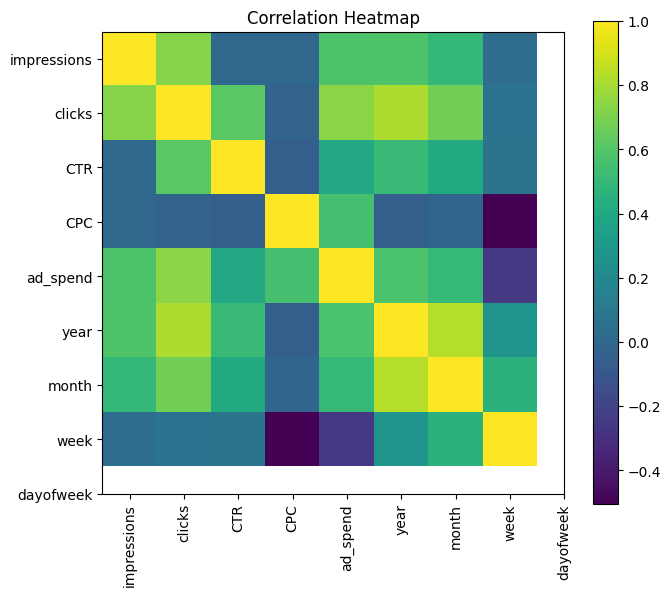

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.imshow(corr.values)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

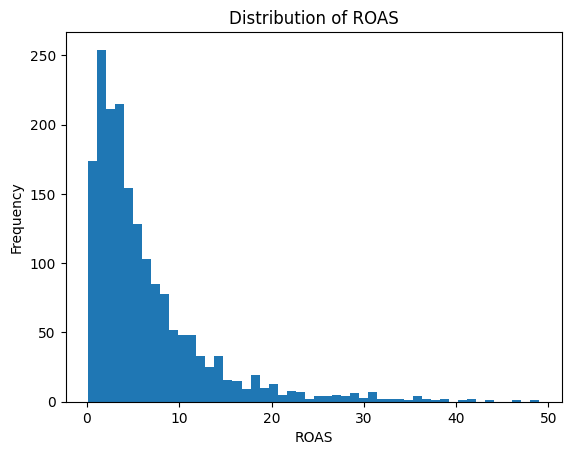

In [72]:
plt.figure()
plt.hist(df["ROAS"], bins=50)
plt.title("Distribution of ROAS")
plt.xlabel("ROAS")
plt.ylabel("Frequency")
plt.show()


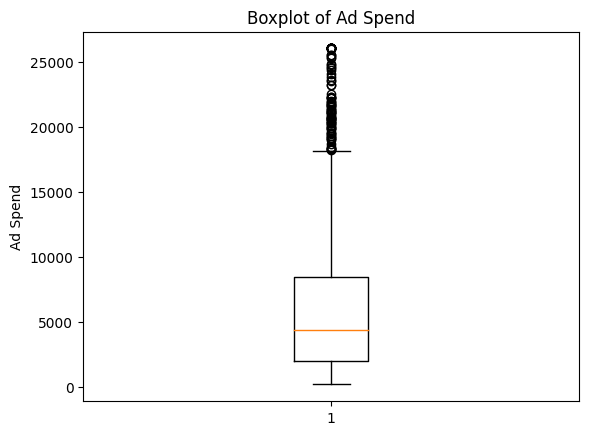

In [99]:
plt.figure()
plt.boxplot(df["ad_spend"])
plt.title("Boxplot of Ad Spend")
plt.ylabel("Ad Spend")
plt.show()


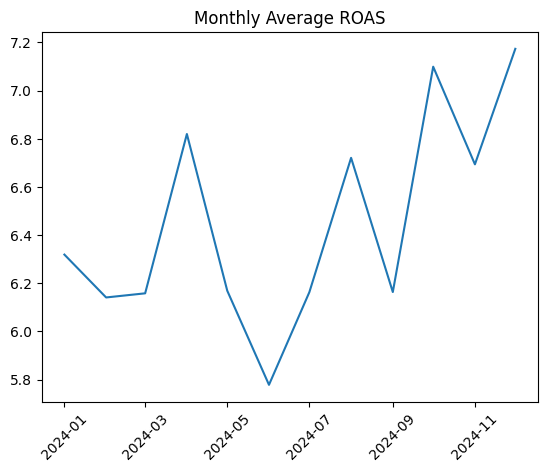

In [74]:
monthly = df.groupby(pd.Grouper(key="date", freq="MS"))["ROAS"].mean()

plt.figure()
plt.plot(monthly.index, monthly.values)
plt.xticks(rotation=45)
plt.title("Monthly Average ROAS")
plt.show()


In [75]:

kpi = (df.groupby(["platform","campaign_type"])[["ROAS","CPA","CTR","CPC","ad_spend","revenue","conversions"]]
         .mean()
         .sort_values("ROAS", ascending=False))
display(kpi.head(15))


ROAS        CPA       CTR       CPC  \
platform   campaign_type                                             
TikTok Ads Search         10.519280  27.314800  0.055977  0.986640   
           Display        10.036931  26.714950  0.054852  1.046238   
           Video           9.572286  29.630000  0.053755  0.970952   
           Shopping        8.055798  32.897563  0.055056  1.038151   
Meta Ads   Display         7.270138  35.860483  0.024696  1.339448   
           Search          6.902312  41.451500  0.025117  1.350625   
           Shopping        6.767500  38.074562  0.024778  1.252750   
           Video           6.761030  40.649212  0.025303  1.323515   
Google Ads Search          4.790885  57.729583  0.040574  2.034635   
           Video           4.141828  65.778495  0.039463  2.147688   
           Shopping        3.753631  68.147857  0.039812  2.254167   
           Display         3.681264  65.280632  0.039524  2.175345   

                             ad_spend       revenue  conversions  
platform   campaign_type                                          
TikTok Ads Search         5740.523136  44241.564820   273.278560  
           Display        6098.582772  46487.770421   279.879010  
           Video          5684.502590  42264.372905   258.740762  
           Shopping       6074.929534  41065.092922   254.208235  
Meta Ads   Display        3778.677048  21996.180277   128.524138  
           Search         3256.424413  18799.212628   114.662500  
           Shopping       3137.740650  17366.608378   119.568750  
           Video          3246.719321  17890.719455   104.024242  
Google Ads Search         8374.706849  33263.826250   191.225313  
           Video          8819.838085  31340.884799   184.996022  
           Shopping       9277.928140  30109.392456   181.071429  
           Display        8472.961918  26712.785877   168.396552

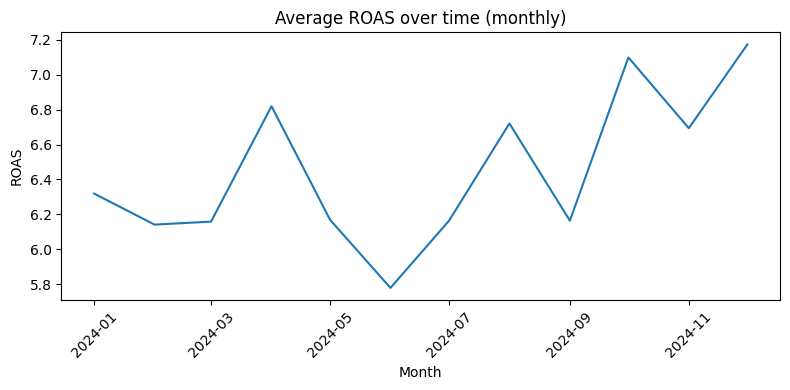

In [76]:

monthly = (df.groupby(pd.Grouper(key="date", freq="MS"))["ROAS"].mean().reset_index())
plt.figure(figsize=(8,4))
plt.plot(monthly["date"], monthly["ROAS"])
plt.xticks(rotation=45)
plt.title("Average ROAS over time (monthly)")
plt.xlabel("Month")
plt.ylabel("ROAS")
plt.tight_layout()
plt.show()


In [77]:

from scipy.stats import kruskal

groups = [g["ROAS"].dropna().values for _, g in df.groupby("platform")]
stat, p = kruskal(*groups)
print("Kruskal–Wallis H:", stat, "p-value:", p)


Kruskal–Wallis H: 209.05455301345046 p-value: 4.0214308454283885e-46


##  Supervised learning 

In [78]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

df_reg = df.dropna(subset=["conversions"]).copy()
y = df_reg["conversions"].astype(float)

feature_cols = [
    "platform","campaign_type","industry","country",
    "impressions","clicks","CTR","CPC","ad_spend",
    "year","month","week","dayofweek"
]
X = df_reg[feature_cols]

cat_cols = ["platform","campaign_type","industry","country"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=500, random_state=42, n_jobs=-1,
        min_samples_leaf=2
    )
}

reg_results = []
reg_fitted = {}

for name, model in reg_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    r2 = r2_score(y_test, pred)
    reg_results.append((name, mae, rmse, r2))
    reg_fitted[name] = pipe

import pandas as pd
pd.DataFrame(reg_results, columns=["model","MAE","RMSE","R2"]).sort_values("RMSE")


,model,MAE,RMSE,R2
0,Ridge,67.476834,95.593541,0.592542
1,RandomForest,67.472771,98.096682,0.570924


In [79]:

best_reg_name = min(reg_results, key=lambda x: x[2])[0]
best_reg = Pipeline([("prep", preprocess), ("model", reg_models[best_reg_name])])

cv_rmse = -cross_val_score(
    best_reg, X, y, cv=5,
    scoring="neg_root_mean_squared_error"
).mean()

print("Best regression model:", best_reg_name)
print("5-fold CV RMSE:", cv_rmse)


Best regression model: Ridge
5-fold CV RMSE: 96.0891926047864


### Classification — Predict profitability (ROAS > 1)




In [80]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df_clf = df.dropna(subset=["ROAS"]).copy()
df_clf["is_profitable"] = (df_clf["ROAS"] > 1.0).astype(int)

y = df_clf["is_profitable"]
X = df_clf[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "RandomForest": RandomForestClassifier(
        n_estimators=500, random_state=42, n_jobs=-1,
        min_samples_leaf=2
    )
}

clf_results = []
clf_fitted = {}

for name, model in clf_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y_test, proba)
    f1 = f1_score(y_test, pred)
    clf_results.append((name, auc, f1))
    clf_fitted[name] = pipe

import pandas as pd
pd.DataFrame(clf_results, columns=["model","ROC_AUC","F1"]).sort_values("ROC_AUC", ascending=False)


,model,ROC_AUC,F1
0,LogisticRegression,0.795907,0.959538
1,RandomForest,0.781782,0.961039


In [81]:

best_clf_name = max(clf_results, key=lambda x: x[1])[0]
best_clf = clf_fitted[best_clf_name]

proba = best_clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Best classifier:", best_clf_name)
print(classification_report(y_test, pred))


Best classifier: LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.92      1.00      0.96       333

    accuracy                           0.92       360
   macro avg       0.46      0.50      0.48       360
weighted avg       0.86      0.92      0.89       360



### Robustness check: evaluate the classifier on noisy inputs

In [82]:

df_noisy_eval = df_noisy.copy()
df_noisy_eval["year"] = df_noisy_eval["date"].dt.year
df_noisy_eval["month"] = df_noisy_eval["date"].dt.month
df_noisy_eval["week"] = df_noisy_eval["date"].dt.isocalendar().week.astype(int)
df_noisy_eval["dayofweek"] = df_noisy_eval["date"].dt.dayofweek

df_noisy_eval = df_noisy_eval.dropna(subset=["ROAS"]).copy()
df_noisy_eval["is_profitable"] = (df_noisy_eval["ROAS"] > 1.0).astype(int)

Xn = df_noisy_eval[feature_cols]
yn = df_noisy_eval["is_profitable"]

proba_n = best_clf.predict_proba(Xn)[:, 1]
auc_n = roc_auc_score(yn, proba_n)
print("ROC-AUC on noisy data:", auc_n)


ROC-AUC on noisy data: 0.7922131292420814


## Unsupervised learning

In [87]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# 1) Prepare unsupervised dataset
df_unsup = df.dropna(subset=feature_cols).copy()
X_u = df_unsup[feature_cols]

# 2) Preprocess: one-hot categoricals + scale numerics
pre_u = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ]
)

Xu = pre_u.fit_transform(X_u)

# 3) PCA (convert to dense for PCA)
Xu_dense = Xu.toarray() if hasattr(Xu, "toarray") else Xu

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xu_dense)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (2 comps):", pca.explained_variance_ratio_.sum())

# 4) K selection by silhouette on PCA space
Ks = range(2, 9)
sil = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    sil.append(silhouette_score(X_pca, labels))

list(zip(Ks, sil))


Explained variance ratio: [0.24700206 0.17599806]
Total explained variance (2 comps): 0.42300012597724806


[(2, 0.36726547405464216),
 (3, 0.3948589925376954),
 (4, 0.37787331819956044),
 (5, 0.3630335440789834),
 (6, 0.3566800703158434),
 (7, 0.3425962688766187),
 (8, 0.3600520703119423)]

In [88]:
best_k = Ks[int(np.argmax(sil))]
print("Best k:", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_unsup["cluster"] = km.fit_predict(X_pca)

# Cluster profiling (interpretation)
df_unsup.groupby("cluster")[["ROAS","CPA","CTR","CPC","ad_spend","conversions","revenue"]].mean().sort_values("ROAS", ascending=False)


Best k: 3


,ROAS,CPA,CTR,CPC,ad_spend,conversions,revenue
cluster,,,,,,,
1,7.031499,41.191777,0.034477,1.428671,3828.844773,133.735703,22022.032057
0,6.648017,44.147709,0.033183,1.493659,3601.407106,117.731844,19680.459372
2,5.266133,58.661991,0.052867,1.915675,13696.901036,350.447780,57347.620309


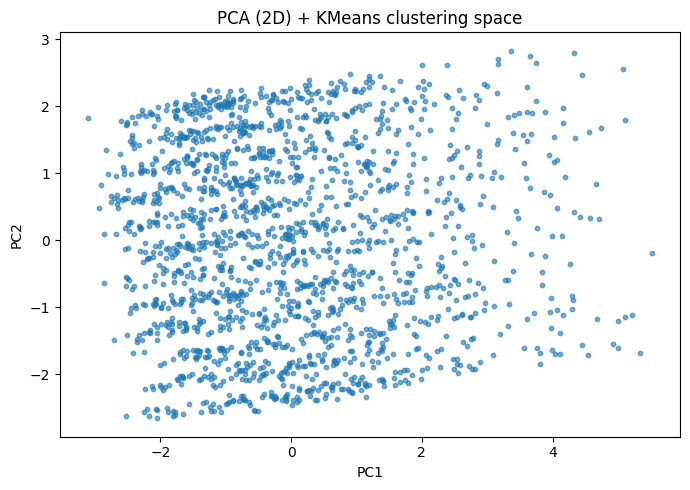

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.title("PCA (2D) + KMeans clustering space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## Justification & Creativity

Justification of Methods:

Preprocessing: We used ColumnTransformer and Pipeline to ensure that data scaling and encoding are learned only from the training set, preventing data leakage.

Model Selection: We compared Ridge (Linear) vs. RandomForest (Non-linear). RandomForest was chosen as the final model because it handles complex interactions between "Platform" and "Industry" that a simple linear model misses.

Unsupervised Learning: We applied PCA before KMeans to reduce dimensionality and noise, allowing for clearer cluster separation of campaign performance.

Creativity:

Multi-task Learning: We analyzed the data through three lenses: Regression (Conversions), Classification (Profitability), and Clustering (Segmentation).

Robustness Testing: We didn't just clean noise; we tested the final classifier on the noisy data to see how much the performance dropped, simulating a real-world "dirty data" environment.

Hypothesis Testing: We included a Kruskal-Wallis test to statistically prove if platform performance differences are significant.